In [1]:
# read raw csv
import glob
import pandas as pd
# read the latest file in the csv folder
# file is obtained by Twitter Media Downloader
# https://memo.furyutei.work/entry/20160723/1469282864
dir = sorted(glob.glob('./CSV/*/'))[-1]
file = glob.glob(dir+'*dryrun.csv')[0]
c_d = pd.read_csv(file,
                      parse_dates=["Tweet date"],
                      skiprows=[0,1,2,3])
c_d

/home/eggplant/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,Tweet date,Action date,Display name,Username,Tweet URL,Media type,Media URL,Saved filename,Remarks,Tweet content,Replies,Retweets,Likes
0,2020-02-20 19:03:38,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12304...,No media,NaN,NaN,NaN,＿人人人人人人人人人人人＿\n＞ 私もロゴが欲しい！ ＜\n￣Y^Y^Y^Y^Y^Y^Y^Y...,NaN,2.0,1.0
1,2020-02-20 14:24:29,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12303...,No media,NaN,NaN,NaN,【チョコレートケーキ】 本日下記の時間でわかめとオクラのサラダ(Lサイズ)を行います！ ミニ...,NaN,1.0,1.0
2,2020-02-20 14:22:20,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12303...,No media,NaN,NaN,NaN,【イカの墨入りスパゲッティ(Wサイズ)】https://twitter.com/delvi5...,NaN,NaN,1.0
3,2020-02-20 10:47:50,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12303...,GIF,https://video.twimg.com/tweet_video/ERLupO_UEA...,minyoruminyon-1230308042555527168-20200220_104...,NaN,https://twitter.com/nishi_shio/status/12303079...,NaN,1.0,6.0
4,2020-02-20 10:44:16,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12303...,No media,NaN,NaN,NaN,અⷬનͥનⷫાͤસͣ https://twitter.com/k1a030371/statu...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50025,2017-06-22 19:30:02,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/87783...,No media,NaN,NaN,NaN,全部実行するつもりなのでしょか？https://twitter.com/ryuichiued...,NaN,5.0,3.0
50026,2017-06-22 19:29:21,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/87783...,No media,NaN,NaN,NaN,ほろーキタコレhttps://twitter.com/ryuichiueda/status/...,NaN,1.0,1.0
50027,2017-06-22 19:19:48,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/87783...,No media,NaN,NaN,NaN,Helloシェル芸bot!https://twitter.com/theoldmoon060...,NaN,1.0,2.0
50028,2017-06-22 19:18:09,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/87783...,No media,NaN,NaN,NaN,HelloWorldhttps://twitter.com/minyoruminyon/st...,NaN,NaN,NaN


In [2]:
# make formatted.csv
import re
newcsv = {'Date':c_d['Tweet date'], 
          'URL': c_d['Tweet URL'],
          'User': [],
          'R+L': c_d['Retweets'].fillna(0) + c_d['Likes'].fillna(0),
          'Retweets': c_d['Retweets'],
          'Likes': c_d['Likes']}

for text in c_d['Tweet content']:
    user = re.search(
        r'https://twitter.com/([a-zA-Z0-9_]+)/status/[0-9]+', text)
    if user:
        user = list(set(user.groups()))
        try:
            user.remove('minyoruminyon')
        except ValueError:
            pass
        try:
            user = user[0]
        except IndexError:
            user = 'minyoruminyon'
    else:
        user = 'minyoruminyon'
    newcsv['User'].append(user)
pd.DataFrame(newcsv).fillna(0).to_csv(dir+'formatted.csv', index=None)
pd.read_csv(dir+'formatted.csv')

,Date,URL,User,R+L,Retweets,Likes
0,2020-02-20 19:03:38,https://twitter.com/minyoruminyon/status/12304...,blacknon_,3.0,2.0,1.0
1,2020-02-20 14:24:29,https://twitter.com/minyoruminyon/status/12303...,delvi511,2.0,1.0,1.0
2,2020-02-20 14:22:20,https://twitter.com/minyoruminyon/status/12303...,delvi511,1.0,0.0,1.0
3,2020-02-20 10:47:50,https://twitter.com/minyoruminyon/status/12303...,nishi_shio,7.0,1.0,6.0
4,2020-02-20 10:44:16,https://twitter.com/minyoruminyon/status/12303...,k1a030371,0.0,0.0,0.0
...,...,...,...,...,...,...
50025,2017-06-22 19:30:02,https://twitter.com/minyoruminyon/status/87783...,ryuichiueda,8.0,5.0,3.0
50026,2017-06-22 19:29:21,https://twitter.com/minyoruminyon/status/87783...,ryuichiueda,2.0,1.0,1.0
50027,2017-06-22 19:19:48,https://twitter.com/minyoruminyon/status/87783...,theoldmoon0602,3.0,1.0,2.0
50028,2017-06-22 19:18:09,https://twitter.com/minyoruminyon/status/87783...,minyoruminyon,0.0,0.0,0.0


In [3]:
# read formatted.csv
import pandas as pd
from scipy import stats
import csv
f_d = pd.read_csv(dir+'formatted.csv')
# make user.csv
userdata = []
c = 1
tmp = None
for k,v in f_d['User'].value_counts().items():
    userdata.append([c,k,v])
    if tmp != v:
        c += 1
    if not tmp:
        tmp = v
    tmp = v
with open(dir+'user.csv', 'w') as f:
    w = csv.writer(f)
    w.writerow(['Rank', 'User', 'Count'])
    w.writerows(userdata)
pd.read_csv(dir+'user.csv')

,Rank,User,Count
0,1,jiro_saburomaru,4727
1,2,ryuichiueda,4236
2,3,blacknon_,3114
3,4,qwertanus,2282
4,5,yami_buta,2246
...,...,...,...
1659,149,172081,1
1660,149,HlBIKI,1
1661,149,hotwatermorning,1
1662,149,NakadEngineer,1


In [4]:
# make buzz.csv
buzz = f_d.sort_values('R+L', ascending=False)
buzz.to_csv(dir+'buzz.csv', index=None)
# reindex
buzz = pd.read_csv(dir+'buzz.csv')
buzz.index = buzz.index + 1
buzz.to_csv(dir+'buzz.csv')
buzz[0:1000].to_csv(dir+'buzz_1000.csv')
pd.read_csv(dir+'buzz_1000.csv')

,Unnamed: 0,Date,URL,User,R+L,Retweets,Likes
0,1,2020-01-28 09:02:17,https://twitter.com/minyoruminyon/status/12219...,yami_buta,4438.0,1478.0,2960.0
1,2,2019-05-21 22:08:09,https://twitter.com/minyoruminyon/status/11308...,ryuichiueda,2393.0,978.0,1415.0
2,3,2019-06-30 23:15:50,https://twitter.com/minyoruminyon/status/11453...,yami_buta,949.0,301.0,648.0
3,4,2020-01-29 00:55:40,https://twitter.com/minyoruminyon/status/12221...,yami_buta,674.0,232.0,442.0
4,5,2019-07-25 06:50:41,https://twitter.com/minyoruminyon/status/11541...,jiro_saburomaru,597.0,242.0,355.0
...,...,...,...,...,...,...,...
995,996,2019-05-24 21:37:32,https://twitter.com/minyoruminyon/status/11319...,ryuichiueda,17.0,8.0,9.0
996,997,2019-03-29 23:21:29,https://twitter.com/minyoruminyon/status/11116...,jiro_saburomaru,17.0,11.0,6.0
997,998,2019-08-14 21:27:44,https://twitter.com/minyoruminyon/status/11616...,yami_buta,17.0,7.0,10.0
998,999,2019-06-02 08:17:07,https://twitter.com/minyoruminyon/status/11349...,penerte,17.0,2.0,15.0


In [5]:
# by month
t = pd.read_csv(dir+'formatted.csv')
t['Date'] = pd.to_datetime(t['Date'])
bymonth = []
for y in t['Date'].dt.year.unique()[::-1]:
    for m in range(1,13):
        bymonth.append(["%d/%d" % (y,m),
                       len(t[(t['Date'].dt.year == y)&
                             (t['Date'].dt.month == m)])
                       ])
with open(dir+'month.csv', 'w') as f:
    w = csv.writer(f)
    [w.writerow(i) for i in bymonth]
pd.read_csv(dir+'month.csv')

,2017/1,0
0,2017/2,0
1,2017/3,0
2,2017/4,0
3,2017/5,0
4,2017/6,622
5,2017/7,571
6,2017/8,325
7,2017/9,279
8,2017/10,302
9,2017/11,181


In [6]:
# by hour
t = pd.read_csv(dir+'formatted.csv')
t['Date'] = pd.to_datetime(t['Date'])
byhour = []
for h in range(0,24):
    byhour.append(["%02d" % h,
                  len(t[(t['Date'].dt.hour == h)])])
with open(dir+'hour.csv', 'w') as f:
    w = csv.writer(f)
    [w.writerow(i) for i in byhour]
pd.read_csv(dir+'hour.csv')

,00,2989
0,1,1712
1,2,961
2,3,557
3,4,426
4,5,362
5,6,607
6,7,1128
7,8,1756
8,9,1961
9,10,2285


In [7]:
# extract some user's one
import os
try:
    os.makedirs(dir+'/user/')
except FileExistsError:
    pass
def extractUser(target):
    n = dir+'/user/%s.csv' % target
    a = pd.read_csv(dir+'formatted.csv')
    a[(a['User'] == target)].to_csv(n, index=False)
    pd.read_csv(n).to_csv(n)
    return pd.read_csv(n)

u = pd.read_csv(dir+'user.csv')
for t in u[(u['Count'] > 9)]['User']:
    print(t,'            ' , end="\r")
    extractUser(t)
print('========END========')

========END========         


In [8]:
u = pd.read_csv(dir+'user.csv')
print(len(u),
      len(u[(u['Count']>9)]))

1664 505


In [9]:
# make user.md
import pytablewriter
writer = pytablewriter.MarkdownTableWriter()
writer.from_dataframe(
    u.replace({'User':r'([0-9_a-zA-Z]+)'}, 
              {'User':r'[\1](https://twitter.com/\1)'},regex=True))
writer.dump(dir+"user.md")
writer.write_table()

|Rank|                         User                         |Count|
|---:|------------------------------------------------------|----:|
|   1|[jiro_saburomaru](https://twitter.com/jiro_saburomaru)| 4727|
|   2|[ryuichiueda](https://twitter.com/ryuichiueda)        | 4236|
|   3|[blacknon_](https://twitter.com/blacknon_)            | 3114|
|   4|[qwertanus](https://twitter.com/qwertanus)            | 2282|
|   5|[yami_buta](https://twitter.com/yami_buta)            | 2246|
|   6|[grethlen](https://twitter.com/grethlen)              | 1188|
|   7|[QiToYtkg](https://twitter.com/QiToYtkg)              | 1145|
|   8|[egpl0](https://twitter.com/egpl0)                    |  967|
|   9|[ytkmns](https://twitter.com/ytkmns)                  |  856|
|  10|[eban](https://twitter.com/eban)                      |  724|
|  11|[shishimy](https://twitter.com/shishimy)              |  597|
|  12|[kino___ma](https://twitter.com/kino___ma)            |  499|
|  13|[CareleSmith9](https://twitter.com/CareleS

In [10]:
# make buzz.md
writer = pytablewriter.MarkdownTableWriter()
b = pd.read_csv(dir+'buzz.csv').replace(
            {'User':r'([0-9_a-zA-Z]+)'}, 
            {'User':r'[\1](https://twitter.com/\1)'},regex=True
    ).replace(
            {'URL':r'(^.*$)'}, 
            {'URL':r'[\1](\1)'},regex=True
    )
writer.from_dataframe(b)
writer.dump(dir+"buzz.md")
writer.from_dataframe(b[0:1000])
writer.dump(dir+"buzz_1000.md")
writer.from_dataframe(b[0:500])
writer.dump(dir+"buzz_500.md")
writer.from_dataframe(b[0:100])
writer.dump(dir+"buzz_100.md")
writer.write_table()

|Unnamed: 0|       Date        |                                                            URL                                                             |                         User                         |R+L |Retweets|Likes|
|---------:|-------------------|----------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------|---:|-------:|----:|
|         1|2020-01-28 09:02:17|[https://twitter.com/minyoruminyon/status/1221946561506078720](https://twitter.com/minyoruminyon/status/1221946561506078720)|[yami_buta](https://twitter.com/yami_buta)            |4438|    1478| 2960|
|         2|2019-05-21 22:08:09|[https://twitter.com/minyoruminyon/status/1130822587242561536](https://twitter.com/minyoruminyon/status/1130822587242561536)|[ryuichiueda](https://twitter.com/ryuichiueda)        |2393|     978| 1415|
|         3|2019-06-30 23:15:50|[https://twitter.com/minyoruminyon/s

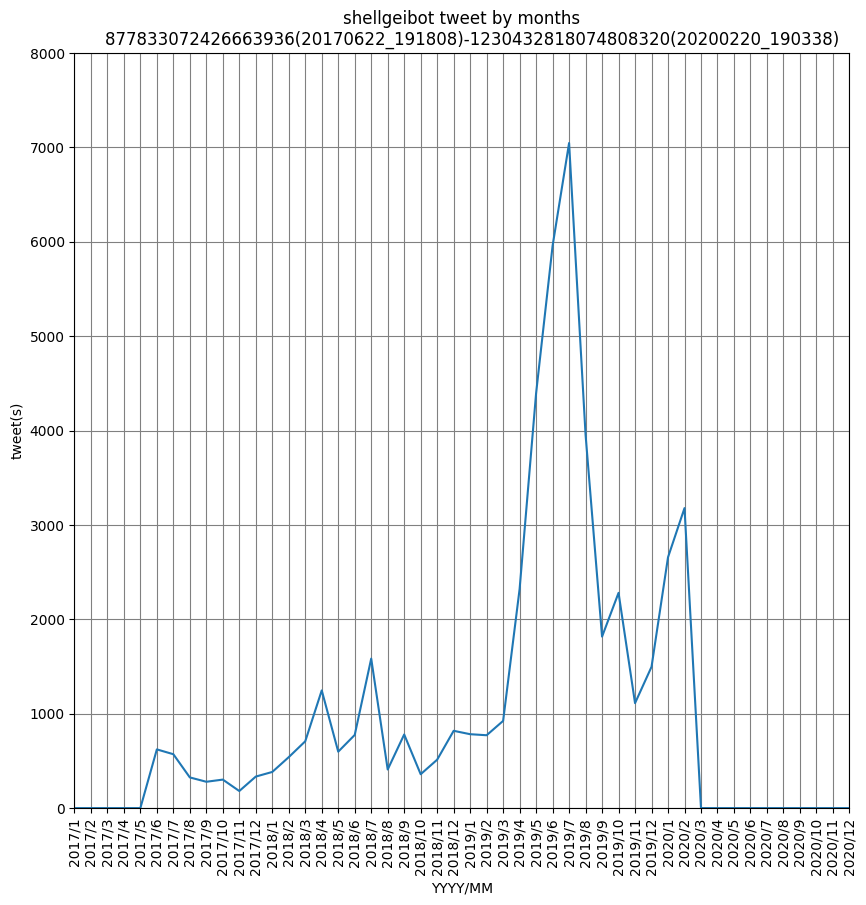

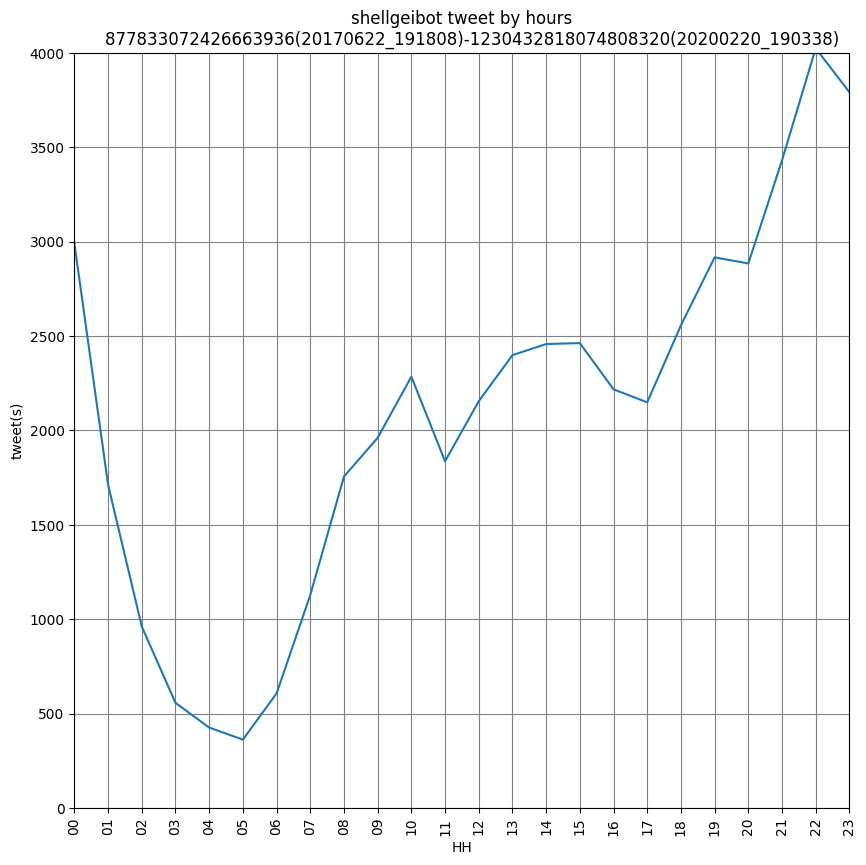

In [11]:
# make graphs
%matplotlib inline
def showgraph(name, title, xlabel, ylim, dir):
    import numpy as np
    import matplotlib.pyplot as plt

    f=[i.split(',') for i in open(name).readlines()]
    x,y=[],[]
    for i in f:
        x.append(i[0])
        y.append(int(i[1]))

    plt.figure(figsize=(10, 10), dpi=100)
    plt.xlim(0,len(x)-1)
    plt.ylim(0,ylim)
    plt.grid(color='gray')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('tweet(s)')
    plt.plot(x, y)
    plt.xticks(rotation=90)
    plt.savefig(dir+title+'.png')
showgraph(
    dir+"month.csv",
    """shellgeibot tweet by months
    %s""" % (file[49:][:-11]),
    "YYYY/MM",
    8000,
    dir
)
showgraph(
    dir+"hour.csv",
    """shellgeibot tweet by hours
    %s""" % (file[49:][:-11]),
    "HH",
    4000,
    dir
)